# Hypothesis Analysis

## Setup environment

### Import Packages

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pathlib
import sys

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
from scipy import signal
import pandas as pd
import ruptures as rpt
from time_window import TimeWindow

from smart_simulation.cfg_templates.config import package_dir

### Connect to data

In [3]:
# Get path to raw weights data
raw_data_path = (
    pathlib.Path(package_dir) / "smart_simulation/outputs/simulations/weights"
)

# List all weights files
flist = [p for p in raw_data_path.iterdir() if p.is_file()]

## Sample EDA

### Raw Data Visualization

In [4]:
# Get sample
sample = pd.read_csv(flist[0], parse_dates=True, index_col=0)
sample.head()

,weight
2020-01-01 00:00:00,14.000000
2020-01-01 06:00:00,13.601856
2020-01-01 12:00:00,13.601856
2020-01-01 18:00:00,13.601856
2020-01-02 00:00:00,13.144815


In [5]:
def plot_weights(dates, weights, title, sample_label, bar=False):
    
    dates_array_shape = dates.shape
    weights_array_shape = weights.shape
    
    if len(dates_array_shape) != 1:
        dates = dates.reshape(-1)
    if len(weights_array_shape) != 1:
        weights = weights.reshape(-1)
    
    days = mdates.WeekdayLocator()
    months = mdates.MonthLocator()
    years = mdates.YearLocator()  
    months_fmt = mdates.DateFormatter('%m')
    
    fig, ax = plt.subplots(figsize=(18, 6))
    
    if bar:
        ax.bar(dates, weights, label=sample_label)
    else:
        ax.plot(dates, weights, label = sample_label)

    locator = mdates.AutoDateLocator()
    formatter = mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_formatter(formatter)
    ax.set(xlabel='Date', ylabel='Weight (oz)', title=title)
    ax.legend()


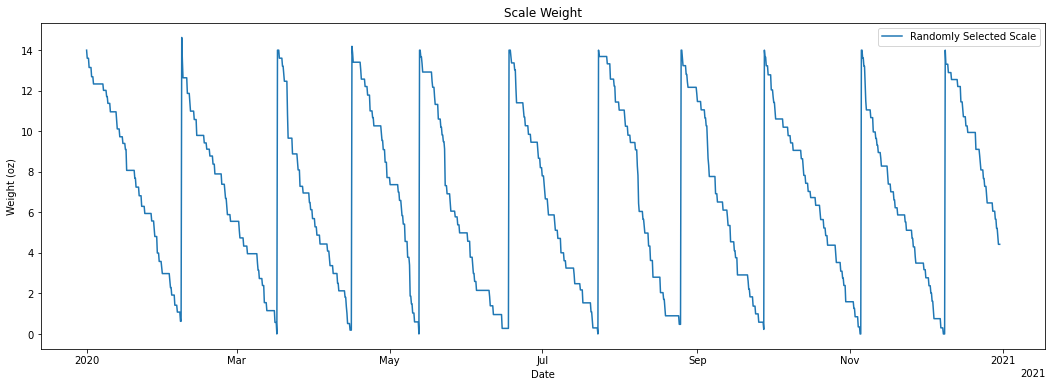

In [6]:
plot_weights(sample.index, sample.values, 'Scale Weight', 'Randomly Selected Scale', bar = False)

### Consumption


In [7]:
raw_consumption = -1 * sample.weight.diff()

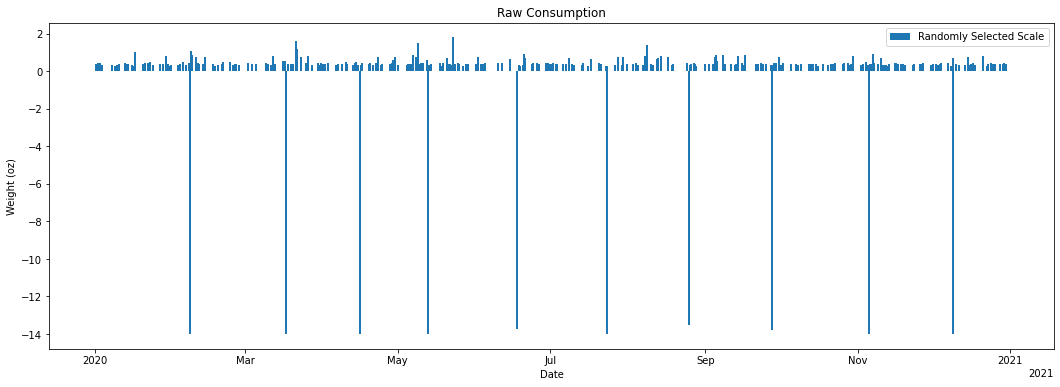

In [8]:
plot_weights(raw_consumption.index, raw_consumption.values, 'Raw Consumption', 'Randomly Selected Scale', bar = True)

#### Raw Frequency Analysis

In [9]:
def calculate_consumption(weight_data):
    raw_consumption = -1 * weight_data.diff()
    raw_consumption.loc[raw_consumption == -0] = 0 # prior transform converts 0 to -0
    with_new_product = raw_consumption.copy()
    with_new_product.loc[raw_consumption < 0] += 14
    return with_new_product

In [785]:
clean_consumption = calculate_consumption(sample.weight)

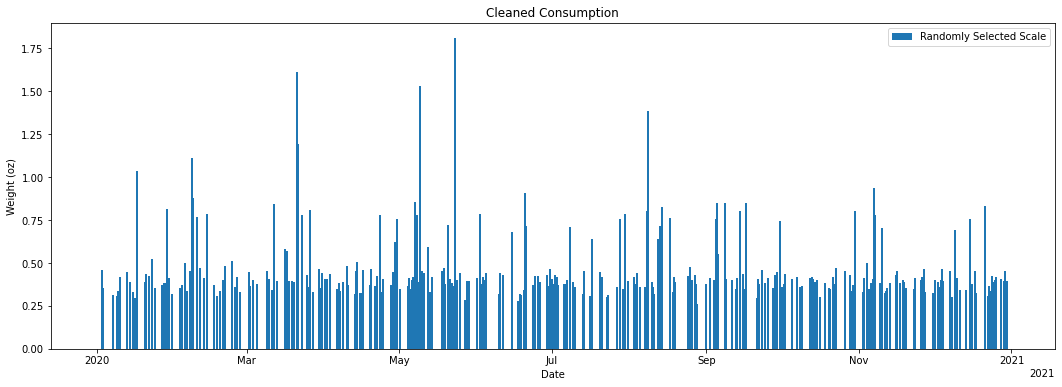

In [786]:
plot_weights(clean_consumption.index, clean_consumption.values, 'Cleaned Consumption', 'Randomly Selected Scale', bar = True)

#### Daily Frequency Analysis

In [787]:
daily_consumption = clean_consumption.resample('1D').sum()

In [788]:
stats = daily_consumption.describe()
print(stats)

count    365.000000
mean       0.407459
std        0.429524
min        0.000000
25%        0.000000
50%        0.388760
75%        0.705150
max        3.039608
Name: weight, dtype: float64


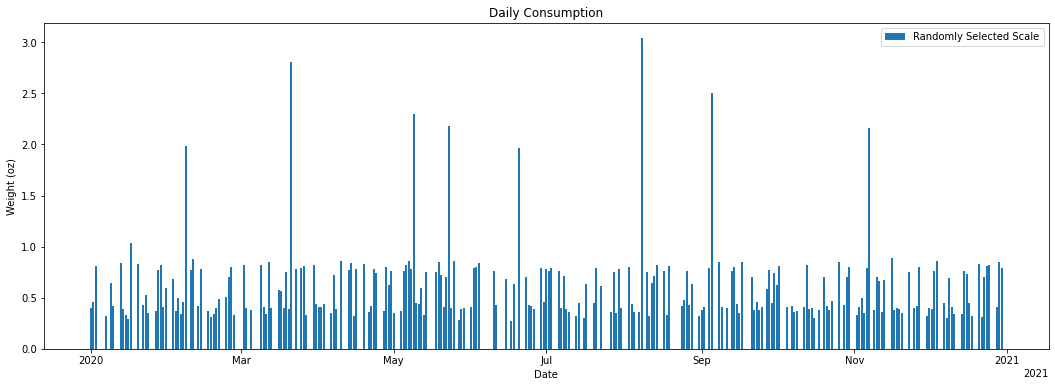

In [13]:
plot_weights(daily_consumption.index, daily_consumption.values, 'Daily Consumption', 'Randomly Selected Scale', bar = True)

#### Day of Week Analysis

In [14]:
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
day_of_week_mean = clean_consumption.groupby(clean_consumption.index.day_name()).mean().reindex(days)
groups_by_day_of_week = clean_consumption.groupby(clean_consumption.index.day_name())

data_with_dow = daily_consumption.copy().to_frame("consumption")
data_with_dow["day_of_week"] = data_with_dow.index.day_name()

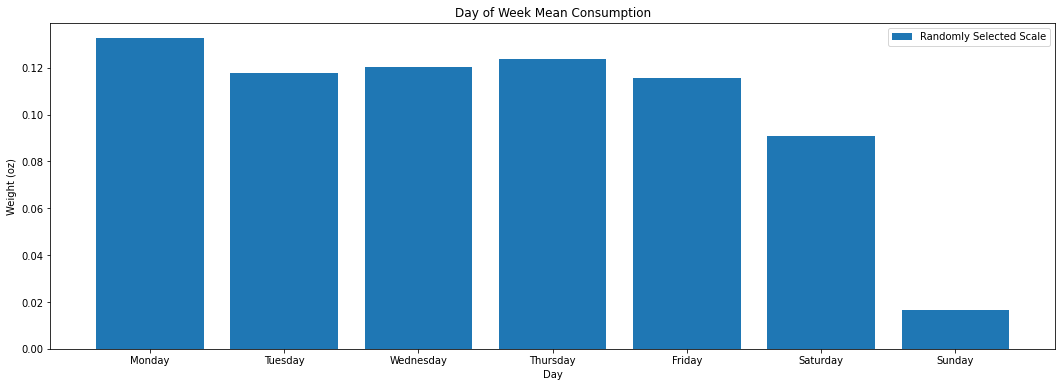

In [15]:
fig, ax = plt.subplots(figsize=(18, 6))
ax.bar(day_of_week_mean.index, day_of_week_mean.values, label='Randomly Selected Scale')
ax.set(xlabel='Day', ylabel='Weight (oz)', title='Day of Week Mean Consumption')
ax.legend()

Text(0.5, 0.98, 'Consumption Distribution of [Sample] by Day of Week')

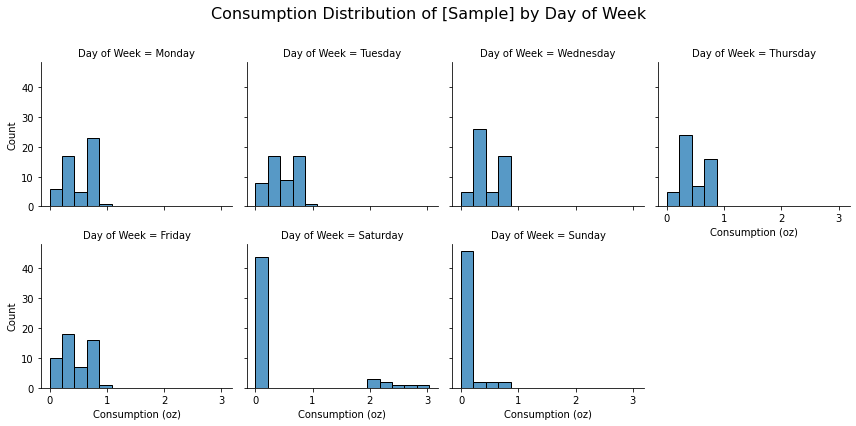

In [56]:
bins=np.linspace(data_with_dow['consumption'].min(), data_with_dow['consumption'].max(), 15)
ax = sns.displot(data_with_dow, x="consumption", col="day_of_week",col_wrap = 4, bins = bins, height=3, aspect=1, facet_kws=dict(col_order=days),)
ax.set_axis_labels("Consumption (oz)", "Count")
ax.set_titles(col_template="Day of Week = {col_name}")
ax.fig.subplots_adjust(top=0.85)
ax.fig.suptitle('Consumption Distribution of [Sample] by Day of Week', fontsize=16)

[Text(0.5, 0, 'Day of Week'),
 Text(0, 0.5, 'Consumption (oz)'),
 Text(0.5, 1.0, 'Consumption analysis of [Sample] by Day of Week')]

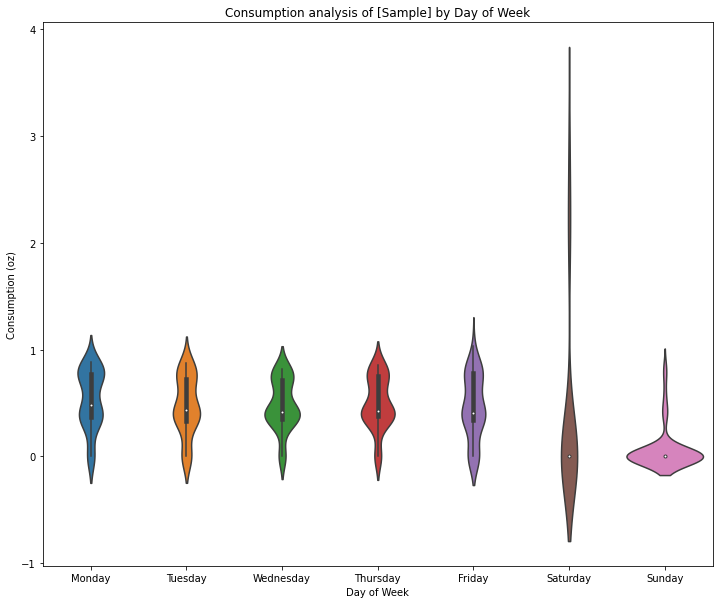

In [58]:
fig, ax = plt.subplots(figsize=(12, 10))
ax = sns.violinplot(x="day_of_week", y="consumption", data=data_with_dow, order=days)
ax.set(xlabel="Day of Week", ylabel="Consumption (oz)", title = 'Consumption analysis of [Sample] by Day of Week')

### Consumption Segments: Segments of consumption for single products 

Objective: Identify change points (resupply dates) to segment into individual product consumption periods.

In [59]:
import ruptures as rpt

In [542]:
def find_break_points(n_products, weight_series, window_width, model='l1'):
    algo = rpt.Window(width=window_width, model=model).fit(weight_series.values)
    break_points = algo.predict(n_bkps=n_products)
    return break_points

In [548]:
def find_peaks(weight_series: pd.Series):
    x = weight_series.values
    peaks = signal.find_peaks(x)[0]
    return peaks

In [593]:
sample_series = pd.Series(sample['weight'])

break_points = find_break_points(10, sample_series, 20, 'l1')
peaks = find_peaks(sample_series)

print(f"Break Points: {break_points}")
print(f"Peaks: {peaks}")

Break Points: [150, 305, 425, 530, 675, 820, 950, 1085, 1240, 1370, 1460]
Peaks: [ 152  306  424  532  676  818  950 1083 1238 1372]


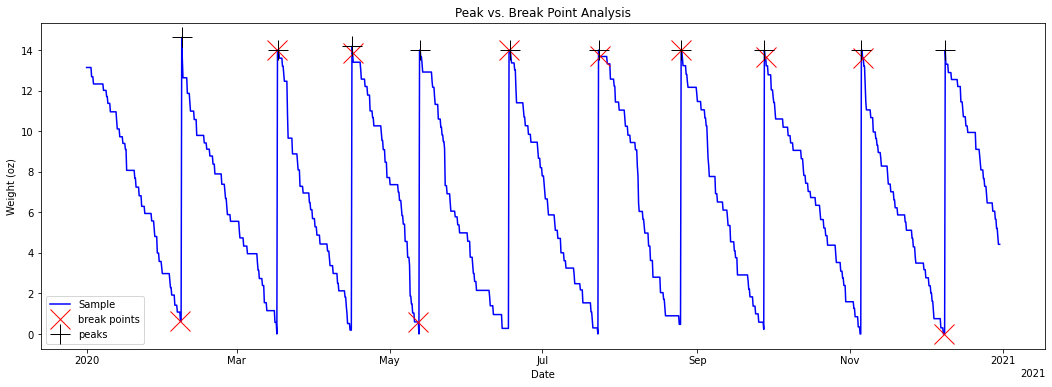

In [594]:
break_points.pop() # final break point is out of range 

dates = sample_series.index
weights = sample_series.values.reshape(-1)

break_points_dt = dates[break_points]
peaks_dt = dates[peaks]

fig, ax = plt.subplots(figsize=(18, 6))
ax.plot(dates, weights, color='blue', label = 'Sample')
ax.plot(dates[break_points], weights[break_points], "x", markersize = 20, color='red', label = 'break points')
ax.plot(dates[peaks], weights[peaks], "+", markersize = 20, color='black', label = 'peaks')
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_formatter(formatter)
ax.set(xlabel='Date', ylabel='Weight (oz)', title="Peak vs. Break Point Analysis")
ax.legend()

#### Validate Segments

In [294]:
def create_consumption_segments(weights_series: pd.Series, break_points: list) -> dict:
    if break_points[-1] >= len(weights_series):
        break_points.pop()
    time_stamps = weights_series.index
    consumption_segments = {}
    
    start_index = 0
    end_index = break_points[0] - 1
    
    start_time_stamp = time_stamps[start_index]
    end_time_stamp = time_stamps[end_index]
    segment_0 = TimeWindow(start_time_stamp, end_time_stamp)
    
    consumption_segments[0] = segment_0
    
    for index, break_point in enumerate(break_points):
        start_index = break_point
        if index < len(break_points) - 1:
            end_index = break_points[index + 1] - 1
        else:
            end_index = -1
        start_time_stamp = time_stamps[start_index]
        end_time_stamp = time_stamps[end_index]

        consumption_segments[index + 1] = TimeWindow(start_time_stamp, end_time_stamp)

    return consumption_segments

        

In [590]:
def create_segment_data(segment: TimeWindow, weight_data: pd.Series) -> dict:
    segment_data = {}
    time_delta = segment.delta 
    start_time = segment.since
    end_time = segment.until
    start_weight = weight_data.loc[start_time]
    end_weight = weight_data.loc[end_time]
    max_weight = weight_data[start_time:end_time].max()
    min_weight = weight_data[start_time:end_time].min()
    max_weight_time = (weight_data[start_time:end_time].loc[weight_data[start_time:end_time] == max_weight]).index[0]
    min_weight_time = (weight_data[start_time:end_time].loc[weight_data[start_time:end_time] == min_weight]).index[-1]
    
    
    segment_data['time_delta'] = time_delta
    segment_data['start_time'] = start_time
    segment_data['end_time'] = end_time

    segment_data['start_weight'] = start_weight
    segment_data['end_weight'] = end_weight
    
    segment_data['max_weight'] = max_weight
    segment_data['min_weight'] = min_weight
    
    segment_data['max_weight_time'] = max_weight_time
    segment_data['min_weight_time'] = min_weight_time
    
    return segment_data

In [624]:
def create_segments_data(consumption_segments: dict, weight_data: pd.Series) -> pd.DataFrame:
    segments_data = pd.DataFrame.from_dict(consumption_segments, orient = 'index', columns = ['time_window'])
    segments_data['time_delta'] = [time_window.delta for time_window in segments_data['time_window']]
    segments_data['start_time'] = [time_window.since for time_window in segments_data['time_window']]
    segments_data['end_time'] = [time_window.until for time_window in segments_data['time_window']]

    segments_data['start_weight'] = [weight_data.loc[start_time] for start_time in segments_data['start_time']]
    segments_data['end_weight'] = [weight_data.loc[end_time] for end_time in segments_data['end_time']]
    
    segments_data['max_weight'] = [weight_data[row.start_time:row.end_time].max() for row in segments_data.itertuples()]
    segments_data['min_weight'] = [weight_data[row.start_time:row.end_time].min() for row in segments_data.itertuples()]
    
    segments_data['max_weight_time'] = [((weight_data[row.start_time:row.end_time].loc[weight_data[row.start_time:row.end_time] == row.max_weight]).index[0]) for row in segments_data.itertuples()]
    segments_data['min_weight_time'] = [((weight_data[row.start_time:row.end_time].loc[weight_data[row.start_time:row.end_time] == row.min_weight]).index[-1]) for row in segments_data.itertuples()]
    
    segments_data = segments_data[['time_delta','start_time', 'max_weight_time', 'end_time', 'min_weight_time', 'start_weight', 'max_weight', 'end_weight', 'min_weight']]
    
    return segments_data

In [625]:
def segements_misaligned(segments_data: pd.DataFrame) -> bool:
    misaligned = False
    for segment_index in segments_data.index:
        if segments_data.at[segment_index, 'start_time'] != segments_data.at[segment_index, 'max_weight_time']:
            misaligned = True
        if segments_data.at[segment_index, 'end_time'] != segments_data.at[segment_index, 'min_weight_time']:
            misaligned = True
        if segment_index < segments_data.index[-1]:
            if segments_data.at[segment_index, 'end_weight'] >= segments_data.at[segment_index + 1, 'start_weight']:
                misaligned = True
    return misaligned


In [677]:
def precise_segments(consumption_segments: dict, weight_series: pd.Series):
    
    segments = consumption_segments.copy()
    
    for segment_index in range(len(segments) - 1):
        current_segment_data = create_segment_data(segments[segment_index], weight_series)
        next_segment_data = create_segment_data(segments[segment_index + 1], weight_series)
        
        current_end_weight = current_segment_data['end_weight']
        next_start_weight = next_segment_data['start_weight']
        
        if current_end_weight >= next_start_weight:
            weight_sub_range = weight_series[current_segment_data['min_weight_time']: next_segment_data['end_time']]
            sub_range_values = np.array(weight_sub_range.values)
            sub_range_times = weight_sub_range.index
            peaks, plateus = signal.find_peaks(sub_range_values, plateau_size=1)
            first_maxima_index = peaks[0]
            if plateus['left_edges']:
                plateus_left_edge = plateus['left_edges']
                first_maxima_index = np.minimum(peaks, plateus_left_edge)[0]
            
            adjusted_current_end_time = sub_range_times[first_maxima_index - 1]
            adjusted_next_start_time = sub_range_times[first_maxima_index]

            adjusted_current_segment = TimeWindow(current_segment_data['start_time'], adjusted_current_end_time)
            adjusted_next_segment = TimeWindow(adjusted_next_start_time, next_segment_data['end_time'])

            segments[segment_index] = adjusted_current_segment
            segments[segment_index + 1] = adjusted_next_segment
        else:
            continue
    
    return segments

In [626]:
bkpt_segments = create_consumption_segments(sample_series, break_points)
peak_segments = create_consumption_segments(sample_series, peaks)

bkpt_segments_data = create_segments_data(bkpt_segments, sample_series)
peak_segments_data = create_segments_data(peak_segments, sample_series)

In [628]:
bkpt_misaligned = segements_misaligned(bkpt_segments_data)
print(f"\nBreak Point Segments Misaligned: {bkpt_misaligned}\n")
bkpt_segments_data


Break Point Segments Misaligned: True



,time_delta,start_time,max_weight_time,end_time,min_weight_time,start_weight,max_weight,end_weight,min_weight
0,37 days 06:00:00,2020-01-01 00:00:00,2020-01-01 00:00:00,2020-02-07 06:00:00,2020-02-07 06:00:00,13.144815,13.144815,1.079715,1.079715
1,38 days 12:00:00,2020-02-07 12:00:00,2020-02-08 00:00:00,2020-03-17 00:00:00,2020-03-17 00:00:00,0.626084,14.626084,0.000000,0.000000
2,29 days 18:00:00,2020-03-17 06:00:00,2020-04-16 00:00:00,2020-04-16 00:00:00,2020-04-15 18:00:00,14.000000,14.189618,14.189618,0.189618
3,26 days 00:00:00,2020-04-16 06:00:00,2020-04-16 06:00:00,2020-05-12 06:00:00,2020-05-12 06:00:00,13.863917,13.863917,0.595371,0.595371
4,36 days 00:00:00,2020-05-12 12:00:00,2020-05-13 00:00:00,2020-06-17 12:00:00,2020-05-12 18:00:00,0.595371,14.000000,0.275799,0.000000
5,36 days 00:00:00,2020-06-17 18:00:00,2020-06-17 18:00:00,2020-07-23 18:00:00,2020-07-23 06:00:00,14.000000,14.000000,13.687529,0.000000
6,32 days 06:00:00,2020-07-24 00:00:00,2020-07-24 00:00:00,2020-08-25 06:00:00,2020-08-25 06:00:00,13.687529,13.687529,0.475203,0.475203
7,33 days 12:00:00,2020-08-25 12:00:00,2020-08-25 12:00:00,2020-09-28 00:00:00,2020-09-27 12:00:00,14.000000,14.000000,13.657577,0.224949
8,38 days 12:00:00,2020-09-28 06:00:00,2020-11-05 12:00:00,2020-11-05 18:00:00,2020-11-05 06:00:00,13.657577,14.000000,14.000000,0.000000
9,32 days 06:00:00,2020-11-06 00:00:00,2020-11-06 00:00:00,2020-12-08 06:00:00,2020-12-08 06:00:00,13.616803,13.616803,0.000000,0.000000


In [629]:
peaks_misaligned = segements_misaligned(peak_segments_data)
print(f"\nPeak Segments Misaligned: {peaks_misaligned}\n")
peak_segments_data


Peak Segments Misaligned: True



,time_delta,start_time,max_weight_time,end_time,min_weight_time,start_weight,max_weight,end_weight,min_weight
0,37 days 18:00:00,2020-01-01 00:00:00,2020-01-01 00:00:00,2020-02-07 18:00:00,2020-02-07 18:00:00,13.144815,13.144815,0.626084,0.626084
1,38 days 06:00:00,2020-02-08 00:00:00,2020-02-08 00:00:00,2020-03-17 06:00:00,2020-03-17 00:00:00,14.626084,14.626084,14.000000,0.000000
2,29 days 06:00:00,2020-03-17 12:00:00,2020-03-17 12:00:00,2020-04-15 18:00:00,2020-04-15 18:00:00,14.000000,14.000000,0.189618,0.189618
3,26 days 18:00:00,2020-04-16 00:00:00,2020-04-16 00:00:00,2020-05-12 18:00:00,2020-05-12 18:00:00,14.189618,14.189618,0.000000,0.000000
4,35 days 18:00:00,2020-05-13 00:00:00,2020-05-13 00:00:00,2020-06-17 18:00:00,2020-06-17 12:00:00,14.000000,14.000000,14.000000,0.275799
5,35 days 06:00:00,2020-06-18 00:00:00,2020-06-18 00:00:00,2020-07-23 06:00:00,2020-07-23 06:00:00,14.000000,14.000000,0.000000,0.000000
6,32 days 18:00:00,2020-07-23 12:00:00,2020-07-23 12:00:00,2020-08-25 06:00:00,2020-08-25 06:00:00,14.000000,14.000000,0.475203,0.475203
7,33 days 00:00:00,2020-08-25 12:00:00,2020-08-25 12:00:00,2020-09-27 12:00:00,2020-09-27 12:00:00,14.000000,14.000000,0.224949,0.224949
8,38 days 12:00:00,2020-09-27 18:00:00,2020-09-27 18:00:00,2020-11-05 06:00:00,2020-11-05 06:00:00,14.000000,14.000000,0.000000,0.000000
9,33 days 06:00:00,2020-11-05 12:00:00,2020-11-05 12:00:00,2020-12-08 18:00:00,2020-12-08 18:00:00,14.000000,14.000000,0.000000,0.000000


In [678]:
bkpt_segments_fixed = precise_segments(bkpt_segments, sample_series)
peak_segments_fixed = precise_segments(peak_segments, sample_series)

bkpt_segments_data_fixed = create_segments_data(bkpt_segments_fixed, sample_series)
peak_segments_data_fixed = create_segments_data(peak_segments_fixed, sample_series)

In [679]:
bkpt_fixed_misaligned = segements_misaligned(bkpt_segments_data_fixed)
print(f"\nFixed Break Point Segments Misaligned: {bkpt_fixed_misaligned}\n")
bkpt_segments_data_fixed


Fixed Break Point Segments Misaligned: False



,time_delta,start_time,max_weight_time,end_time,min_weight_time,start_weight,max_weight,end_weight,min_weight
0,37 days 18:00:00,2020-01-01 00:00:00,2020-01-01 00:00:00,2020-02-07 18:00:00,2020-02-07 18:00:00,13.144815,13.144815,0.626084,0.626084
1,38 days 00:00:00,2020-02-08 00:00:00,2020-02-08 00:00:00,2020-03-17 00:00:00,2020-03-17 00:00:00,14.626084,14.626084,0.000000,0.000000
2,29 days 12:00:00,2020-03-17 06:00:00,2020-03-17 06:00:00,2020-04-15 18:00:00,2020-04-15 18:00:00,14.000000,14.000000,0.189618,0.189618
3,26 days 18:00:00,2020-04-16 00:00:00,2020-04-16 00:00:00,2020-05-12 18:00:00,2020-05-12 18:00:00,14.189618,14.189618,0.000000,0.000000
4,35 days 12:00:00,2020-05-13 00:00:00,2020-05-13 00:00:00,2020-06-17 12:00:00,2020-06-17 12:00:00,14.000000,14.000000,0.275799,0.275799
5,35 days 12:00:00,2020-06-17 18:00:00,2020-06-17 18:00:00,2020-07-23 06:00:00,2020-07-23 06:00:00,14.000000,14.000000,0.000000,0.000000
6,32 days 18:00:00,2020-07-23 12:00:00,2020-07-23 12:00:00,2020-08-25 06:00:00,2020-08-25 06:00:00,14.000000,14.000000,0.475203,0.475203
7,33 days 00:00:00,2020-08-25 12:00:00,2020-08-25 12:00:00,2020-09-27 12:00:00,2020-09-27 12:00:00,14.000000,14.000000,0.224949,0.224949
8,38 days 12:00:00,2020-09-27 18:00:00,2020-09-27 18:00:00,2020-11-05 06:00:00,2020-11-05 06:00:00,14.000000,14.000000,0.000000,0.000000
9,33 days 06:00:00,2020-11-05 12:00:00,2020-11-05 12:00:00,2020-12-08 18:00:00,2020-12-08 18:00:00,14.000000,14.000000,0.000000,0.000000


In [680]:
peaks_fixed_misaligned = segements_misaligned(peak_segments_data_fixed)
print(f"\nFixed Peak Segments Misaligned: {peaks_fixed_misaligned}\n")
peak_segments_data_fixed


Fixed Peak Segments Misaligned: False



,time_delta,start_time,max_weight_time,end_time,min_weight_time,start_weight,max_weight,end_weight,min_weight
0,37 days 18:00:00,2020-01-01 00:00:00,2020-01-01 00:00:00,2020-02-07 18:00:00,2020-02-07 18:00:00,13.144815,13.144815,0.626084,0.626084
1,38 days 00:00:00,2020-02-08 00:00:00,2020-02-08 00:00:00,2020-03-17 00:00:00,2020-03-17 00:00:00,14.626084,14.626084,0.000000,0.000000
2,29 days 12:00:00,2020-03-17 06:00:00,2020-03-17 06:00:00,2020-04-15 18:00:00,2020-04-15 18:00:00,14.000000,14.000000,0.189618,0.189618
3,26 days 18:00:00,2020-04-16 00:00:00,2020-04-16 00:00:00,2020-05-12 18:00:00,2020-05-12 18:00:00,14.189618,14.189618,0.000000,0.000000
4,35 days 12:00:00,2020-05-13 00:00:00,2020-05-13 00:00:00,2020-06-17 12:00:00,2020-06-17 12:00:00,14.000000,14.000000,0.275799,0.275799
5,35 days 12:00:00,2020-06-17 18:00:00,2020-06-17 18:00:00,2020-07-23 06:00:00,2020-07-23 06:00:00,14.000000,14.000000,0.000000,0.000000
6,32 days 18:00:00,2020-07-23 12:00:00,2020-07-23 12:00:00,2020-08-25 06:00:00,2020-08-25 06:00:00,14.000000,14.000000,0.475203,0.475203
7,33 days 00:00:00,2020-08-25 12:00:00,2020-08-25 12:00:00,2020-09-27 12:00:00,2020-09-27 12:00:00,14.000000,14.000000,0.224949,0.224949
8,38 days 12:00:00,2020-09-27 18:00:00,2020-09-27 18:00:00,2020-11-05 06:00:00,2020-11-05 06:00:00,14.000000,14.000000,0.000000,0.000000
9,33 days 06:00:00,2020-11-05 12:00:00,2020-11-05 12:00:00,2020-12-08 18:00:00,2020-12-08 18:00:00,14.000000,14.000000,0.000000,0.000000


#### Analyze consumption rates for each segment

In [746]:
def segment_consumption_stats(segments, weight_series):
    segments_data = create_segments_data(segments, weight_series)
    clean_consumption = calculate_consumption(weight_series)
    daily_consumption = clean_consumption.resample('1D').sum()
    segments_stats_dict = {}
    for segment in segments_data.itertuples():
        segment_consumption = daily_consumption[segment.start_time: segment.end_time]
        segment_stats = segment_consumption.describe()
        segments_stats_dict[segment.Index] = segment_stats.to_dict()
    
    stats_df = pd.DataFrame.from_dict(segments_stats_dict).T
    segments_stats = segments_data[['time_delta', 'start_time', 'end_time']]
    segments_stats = pd.concat([segments_stats, stats_df], axis=1)

    return segments_stats

In [750]:
segments_stats = segment_consumption_stats(peak_segments_fixed, sample_series)
segments_stats

,time_delta,start_time,end_time,count,mean,std,min,25%,50%,75%,max
0,37 days 18:00:00,2020-01-01 00:00:00,2020-02-07 18:00:00,38.0,0.329440,0.316646,0.0,0.000000,0.345279,0.517144,1.033988
1,38 days 00:00:00,2020-02-08 00:00:00,2020-03-17 00:00:00,39.0,0.375028,0.407378,0.0,0.000000,0.369491,0.575329,1.988914
2,29 days 12:00:00,2020-03-17 06:00:00,2020-04-15 18:00:00,29.0,0.476220,0.550591,0.0,0.000000,0.395173,0.770927,2.807516
3,26 days 18:00:00,2020-04-16 00:00:00,2020-05-12 18:00:00,27.0,0.525541,0.477599,0.0,0.174862,0.452132,0.780332,2.296751
4,35 days 12:00:00,2020-05-13 00:00:00,2020-06-17 12:00:00,36.0,0.388889,0.451734,0.0,0.000000,0.361190,0.729070,2.175321
5,35 days 12:00:00,2020-06-17 18:00:00,2020-07-23 06:00:00,36.0,0.397569,0.405915,0.0,0.000000,0.396421,0.655398,1.966915
6,32 days 18:00:00,2020-07-23 12:00:00,2020-08-25 06:00:00,33.0,0.414774,0.566048,0.0,0.000000,0.361024,0.712998,3.039608
7,33 days 00:00:00,2020-08-25 12:00:00,2020-09-27 12:00:00,33.0,0.424242,0.478539,0.0,0.000000,0.399260,0.638862,2.500302
8,38 days 12:00:00,2020-09-27 18:00:00,2020-11-05 06:00:00,39.0,0.358974,0.285686,0.0,0.000000,0.389737,0.485553,0.853801
9,33 days 06:00:00,2020-11-05 12:00:00,2020-12-08 18:00:00,33.0,0.424242,0.430913,0.0,0.000000,0.388760,0.668963,2.156088


In [791]:
consumption_analysis = daily_consumption.copy().to_frame("consumption")
consumption_analysis['consumption_segment'] = np.nan

for row in segments_stats.itertuples():
    consumption_analysis.at[row.start_time:row.end_time, 'consumption_segment'] = int(row.Index)


[Text(0.5, 0, 'Consumption Segment'),
 Text(0, 0.5, 'Consumption (oz)'),
 Text(0.5, 1.0, 'Consumption analysis of [Sample] by Segment')]

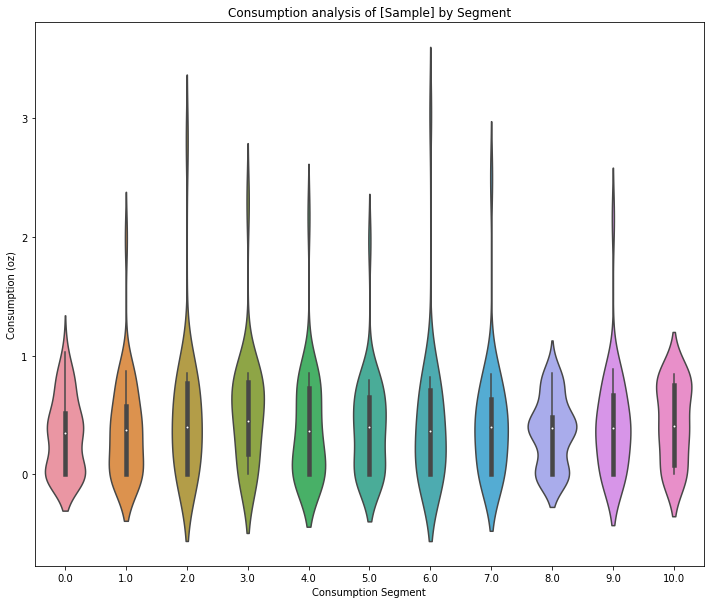

In [790]:
fig, ax = plt.subplots(figsize=(12, 10))
ax = sns.violinplot(x="consumption_segment", y="consumption", data=consumption_analysis)
ax.set(xlabel="Consumption Segment", ylabel="Consumption (oz)", title = 'Consumption analysis of [Sample] by Segment')

### Analyze consumption rates for rolling 3, 7, 10, 14, 21 day & alltime averages

In [795]:
consumption_rolling_analysis = daily_consumption.copy().to_frame("consumption")
consumption_rolling_analysis['3D_SMA'] = consumption_rolling_analysis.loc[:, 'consumption'].rolling(window='3D').mean()
consumption_rolling_analysis['7D_SMA'] = consumption_rolling_analysis.loc[:, 'consumption'].rolling(window='7D').mean()
consumption_rolling_analysis['14D_SMA'] = consumption_rolling_analysis.loc[:, 'consumption'].rolling(window='14D').mean()
consumption_rolling_analysis['21D_SMA'] = consumption_rolling_analysis.loc[:, 'consumption'].rolling(window='21D').mean()
consumption_rolling_analysis['30D_SMA'] = consumption_rolling_analysis.loc[:, 'consumption'].rolling(window='30D').mean()

In [796]:
consumption_rolling_analysis

,consumption,3D_SMA,7D_SMA,14D_SMA,21D_SMA,30D_SMA
2020-01-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-03,0.811885,0.270628,0.270628,0.270628,0.270628,0.270628
2020-01-04,0.000000,0.270628,0.202971,0.202971,0.202971,0.202971
2020-01-05,0.000000,0.270628,0.162377,0.162377,0.162377,0.162377
...,...,...,...,...,...,...
2020-12-26,0.000000,0.542614,0.496664,0.434777,0.394807,0.394387
2020-12-27,0.000000,0.272722,0.496664,0.434777,0.394807,0.367741
2020-12-28,0.407168,0.135723,0.435744,0.439308,0.392627,0.381313
2020-12-29,0.846739,0.417969,0.512521,0.445605,0.418567,0.409538


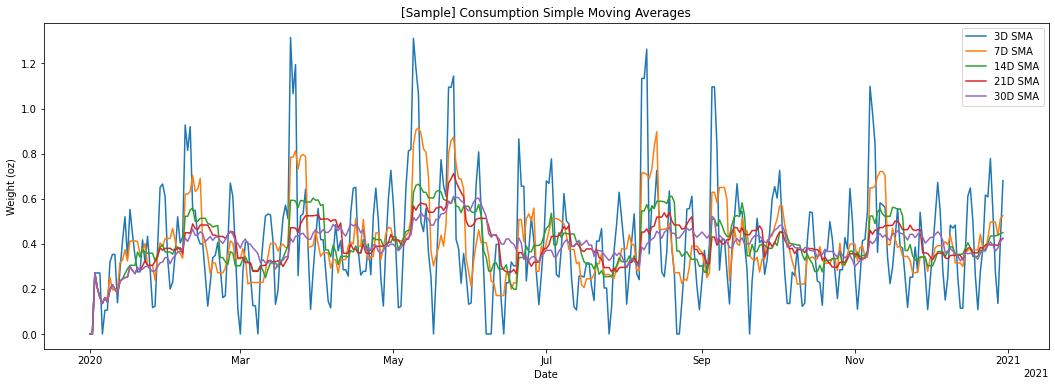

In [802]:
dates = consumption_rolling_analysis.index

days = mdates.WeekdayLocator()
months = mdates.MonthLocator()
years = mdates.YearLocator()  
months_fmt = mdates.DateFormatter('%m')

fig, ax = plt.subplots(figsize=(18, 6))

ax.plot(dates, consumption_rolling_analysis['3D_SMA'], label = '3D SMA')
ax.plot(dates, consumption_rolling_analysis['7D_SMA'], label = '7D SMA')
ax.plot(dates, consumption_rolling_analysis['14D_SMA'], label = '14D SMA')
ax.plot(dates, consumption_rolling_analysis['21D_SMA'], label = '21D SMA')
ax.plot(dates, consumption_rolling_analysis['30D_SMA'], label = '30D SMA')

locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_formatter(formatter)
ax.set(xlabel='Date', ylabel='Weight (oz)', title='[Sample] Consumption Simple Moving Averages')
ax.legend()


In [803]:
consumption_rolling_analysis.describe()

,consumption,3D_SMA,7D_SMA,14D_SMA,21D_SMA,30D_SMA
count,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000
mean,0.407459,0.405247,0.403836,0.400814,0.398866,0.397252
std,0.429524,0.245031,0.156125,0.113364,0.095714,0.081325
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.253844,0.314273,0.329049,0.337319,0.353706
50%,0.388760,0.377040,0.378105,0.371069,0.389148,0.403108
75%,0.705150,0.532329,0.450272,0.480797,0.464638,0.441191
max,3.039608,1.315239,0.914895,0.664170,0.711484,0.606904


[Text(0.5, 0, 'SMA Size'),
 Text(0, 0.5, 'Consumption (oz)'),
 Text(0.5, 1.0, '[Sample] Consumption Simple Moving Averages')]

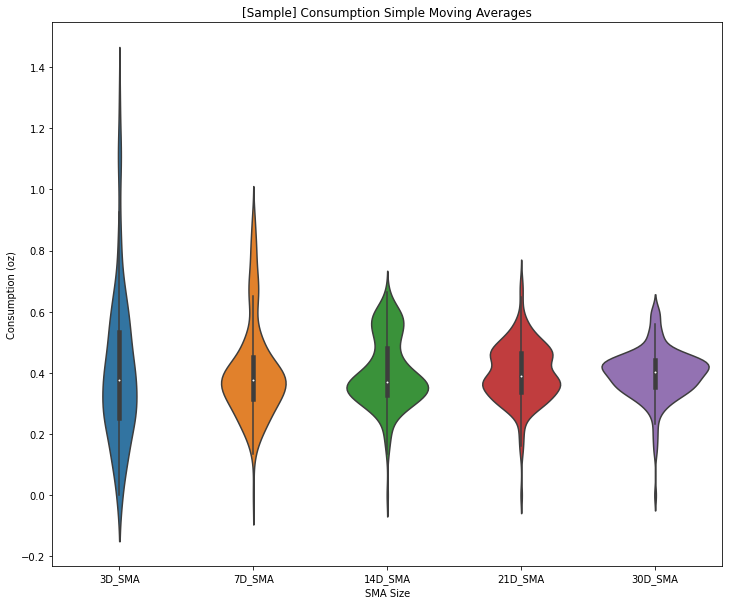

In [811]:
rolling_averages = consumption_rolling_analysis.drop(columns = ['consumption'])
fig, ax = plt.subplots(figsize=(12, 10))
ax = sns.violinplot(data=rolling_averages)
ax.set(xlabel="SMA Size", ylabel="Consumption (oz)", title = '[Sample] Consumption Simple Moving Averages')

# Analysis hypothesis
####  1. Simply checking when scales go to zero isn’t effective because of scale noise
####  2. Using mean-time-to-bag-zero results in low accuracy for predicting the time they finish a bag
####  3. Can predict when customer finishes a bag by fitting a straight line to the last N measurements
####  4. Ship bags way more often than you need to to make customers happy


## Full Training Dataset EDA